# GDF approach description

We will use Gaussian Density Filter (GDF) to extract features from Limited Order Books, which we mid price raise prediction for the next tick. 

The order of this notebook is as follows:
1. Motivation
2. Data preparation:
    * data normalization
    * GDF filtering
    * feature preparation
2. Initial Predictions
3. Conclusions

## Motivation

Limited order book is a list of orders, where order is a tuple $(price, volume)$. For each stock LOB may change every tick. LOBs do not have fixed sizes that is why it is impossible to use them directly as inputs (features) to classyfing algoritms. They hold a lot of noisy, but sometimes useful information. 

The other issue with LOBs is that they are sorted, so it's often that when in tick $i$ order $order(price_n, volume_n)$ is $n$-th element of the LOB, but in tick $i+1$ the same order may become $m$-th element, where $n != m$.

We want to find a way in which we can use information from LOBs.

In [1]:
 %matplotlib inline
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from typing import Tuple
import numpy as np
import itertools
import os

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import warnings

from lob_data_utils import lob, db_result, roc_results

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

## Data preparation

### Data normalization

Let's define LOB in one tick as as $(bid\_list, ask\_list)$ where both `bid_list` and `ask_list` are lists of pairs `(price, volume)`. For each tick we have:

$
\begin{equation*}
    volumes = \{v: (p, v) \in bid\_list  ||  (p, v) \in ask\_list \}
\end{equation*}
$

$ mid\_price = \frac{max(price \in bid\_list) - min(price \in ask\_list)}{2}$

Then normalization of the order `(price, volume)` is a pair `(price_norm, volume_norm)` where:

$$
\begin{equation*}
volume\_norm = \frac{price * volume}{\sum(volumes)} \\
price\_norm = \frac{1000 * (price - mid\_price)}{mid\_price}
\end{equation*}
$$


In [2]:
def transform_to_orders(df: pd.DataFrame) -> pd.DataFrame:
    """
     Orders in data frame are lists of [(price, volume)].
    """
    orders = []
    for idx, row in df.iterrows():
        bid = np.array([literal_eval(row.get('bid'))][0])
        ask = np.array([literal_eval(row.get('ask'))][0])

        mid_price = row['mid_price']

        bid_vol_norm = bid[:, 1] * bid[:, 0]
        ask_vol_norm = ask[:, 1] * ask[:, 0]

        total_capital = bid_vol_norm.sum() + ask_vol_norm.sum()
        bid_vol_norm /= total_capital
        ask_vol_norm /= total_capital

        bid_price_norm = 1000 * (bid[:, 0] - mid_price) / mid_price
        ask_price_norm = 1000 * (ask[:, 0] - mid_price) / mid_price

        o = {}
        o['bid_norm'] = list(zip(bid_price_norm, bid_vol_norm))
        o['ask_norm'] = list(zip(ask_price_norm, ask_vol_norm))
        o['mid_price'] = mid_price
        o['mid_price_indicator'] = row['mid_price_indicator']
        orders.append(o)
    return pd.DataFrame(orders)

### GDF filtering

We are using Gaussian density function as filter for the "noise", since we want to look more on the shape of the data then on exact values.

$f(x;\mu ,\sigma ^{2})=r * {\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}$.


There are two parameters which need to be set:
* $\sigma^2$ - variance (how wide is the gaussian curve)
* $\mu$ - median (location)
* $r$ - scale parameter (how tall is the gaussian curve)

For each LOB we will split it into $K$ segments $(s_0, s_1, \ldots, s_{K-1})$. For each segment $s_i$ we will define the gaussian curve $G_i$ with the parameters: 
* $\sigma$ - variance
* $r$ - scale
* $\frac{s_{i+1} - s_{i}}{2}$ - median

We will calculate area intersection between area of each $G_i$ and orders and we will call it `gdf_i` for each $i \in (0, K)$ (this is very informal description).

We will also calculate `mid_price_index` which will tell us in which `gdf` mid price is located.

In [3]:
def gdf_representation(buy_orders, sell_orders, gdf):
    buy_price, buy_volume = buy_orders
    sell_price, sell_volume = sell_orders
    buy_gdf_y = gdf[0] * norm.pdf(buy_price, loc=gdf[1], scale=gdf[2])
    sell_gdf_y = gdf[0] * norm.pdf(sell_price, loc=gdf[1], scale=gdf[2])
    return np.clip(buy_volume, 0.0, buy_gdf_y).sum() + np.clip(sell_volume, 0.0, sell_gdf_y).sum()


def transform_to_gdf(df: pd.DataFrame, r=0.025, s=0.05, K=50) -> pd.DataFrame:
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(1, K // 2 + 1)])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    order_list = []
    for idx, row in df.iterrows():
        d_bid = np.array([row.get('bid_norm')][0])
        d_ask = np.array([row.get('ask_norm')][0])
        

        new_row_dict = {}
        for i in range(0, K):
            gdf_repr = gdf_representation((d_bid[:, 0], d_bid[:, 1]),
                                          (d_ask[:, 0], d_ask[:, 1]),
                                          gdfs[i, :])
            new_row_dict['gdf_' + str(i)] = gdf_repr
        new_row_dict['mid_price_index'] = len(d_bid)/(len(d_bid)+len(d_ask)) * K
        new_row_dict['mid_price'] = (np.max(d_bid) - np.min(d_ask)) / 2
        new_row_dict['mid_price_indicator'] = row.get('mid_price_indicator')

        order_list.append(new_row_dict)
    order_df = pd.DataFrame(order_list)
    return order_df

In [4]:
stock = '9061'
length = 10000
df, df_cv, df_test= lob.load_prepared_data(stock, data_dir='data/', cv=True, length=length)
df_gdf_example = transform_to_gdf(transform_to_orders(df_cv), K=10)
df_gdf_example.head()

,gdf_0,gdf_1,gdf_2,gdf_3,gdf_4,gdf_5,gdf_6,gdf_7,gdf_8,gdf_9,mid_price,mid_price_index,mid_price_indicator
0,0.021738,0.028745,0.024675,0.007122,0.007091,0.017308,0.017339,0.019849,0.021375,0.019036,0.026232,3.508772,0.0
1,0.031267,0.033193,0.022252,0.025480,0.007833,0.004534,0.017279,0.017350,0.027793,0.030522,0.027020,3.411765,1.0
2,0.021667,0.027262,0.026460,0.011302,0.011278,0.009864,0.009888,0.019059,0.021628,0.022085,0.026750,3.428571,0.0
3,0.025888,0.021047,0.015933,0.020087,0.008753,0.002441,0.013646,0.015803,0.024850,0.026251,0.026465,3.450292,0.0
4,0.028570,0.021729,0.012486,0.000595,0.000134,0.008970,0.013258,0.025474,0.022342,0.021619,0.027529,3.411765,0.0


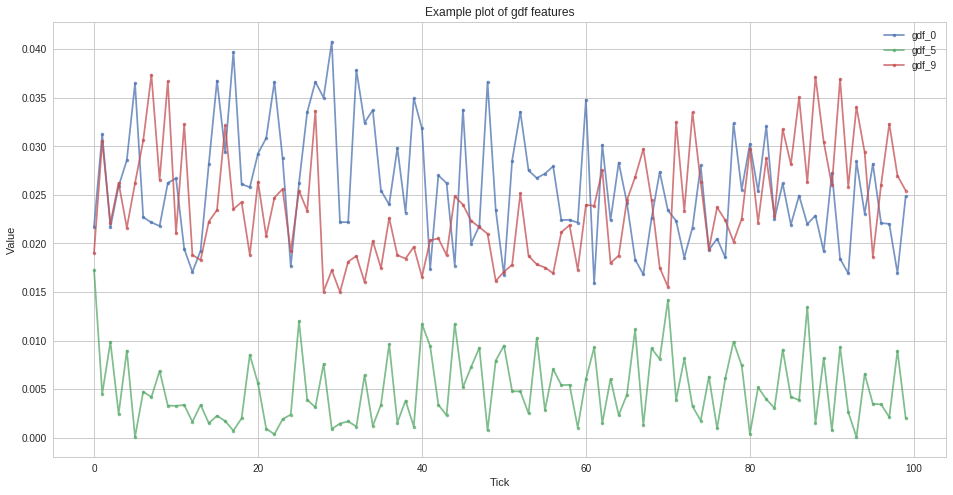

In [5]:
df_gdf_example[['gdf_0', 'gdf_5', 'gdf_9']].iloc[0:100].plot(marker='.', figsize=(16, 8), alpha=0.75)
plt.title('Example plot of gdf features')
plt.ylabel('Value')
plt.xlabel('Tick')

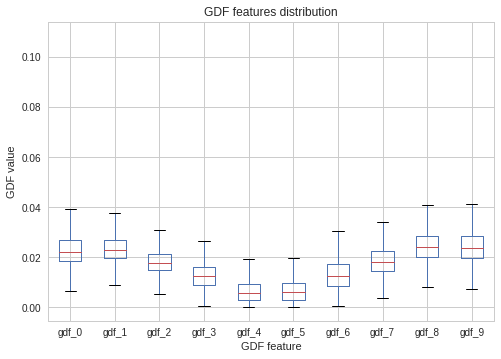

In [6]:
cols = ['gdf_' + str(i) for i in range(0, 10)]
df_gdf_example[cols].plot(kind='box')
plt.title('GDF features distribution')
plt.ylabel('GDF value')
plt.xlabel('GDF feature')

### Feature preparation

Mid price value is between the maximum bid price and minimum ask price. That is why we want to look at `gdf features` which are corresponding to the values close to mid-price. Let's denote number of features we want to use by $ n $. If mid price is located in $ gdf_i $ we will calculate $mgdf_0, mgdf_1, \ldots, mgdf_n$:

* $mgdf_0$ = $gdf_{i-n/2}$
* $mgdf_1$ = $gdf_{i-n/2 + 1}$
* $\ldots$
* $mgdf_n$ = $gdf_{i+n/2}$


This approach assummes that both bid and ask lists are always longer than half of number of features, so we have to pick number of features thoughtfully. We will refer to this features as **close to mid-price features**.

To avoid that issue we could just always pick fixed gdf features indexes, f.e. 
if we calculated `gdf`'s for $K=5$ (so we have $gdf_0, gdf_1, ..., gdf_4$) we will pick always $gdf_2$, $gdf_3$ instead of occasionally picking $gdf_1$ or $gdf_4$ if they are "closer" to mid price.  We will refer to this features as **fixed indexes features**.

I'm not sure which approach is better, most calculations were done for the second one (fixed indexes).

In [7]:
def prepare_features(df, features_num):
    prepared_list = []
    for i, row in df.iterrows():
        prepared = {}
        mid_idx = int(np.floor(row['mid_price_index']))
        for i in range(-features_num//2, features_num//2):
            f_idx = mid_idx + i
            prepared['mgdf_' + str(i + features_num//2)] = row['gdf_' + str(f_idx)]
            prepared['mid_price_indicator'] = row['mid_price_indicator']
        prepared_list.append(prepared)
    return pd.DataFrame(prepared_list)

In [8]:
df_gdf_features_example = prepare_features(df_gdf_example, 4)
df_gdf_features_example.head()

,mgdf_0,mgdf_1,mgdf_2,mgdf_3,mid_price_indicator
0,0.028745,0.024675,0.007122,0.007091,0.0
1,0.033193,0.022252,0.025480,0.007833,1.0
2,0.027262,0.026460,0.011302,0.011278,0.0
3,0.021047,0.015933,0.020087,0.008753,0.0
4,0.021729,0.012486,0.000595,0.000134,0.0


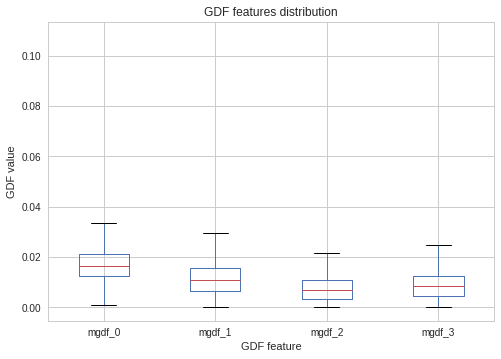

In [9]:
cols = ['mgdf_' + str(i) for i in range(0, 4)]
df_gdf_features_example[cols].plot(kind='box')
plt.title('GDF features distribution')
plt.ylabel('GDF value')
plt.xlabel('GDF feature')

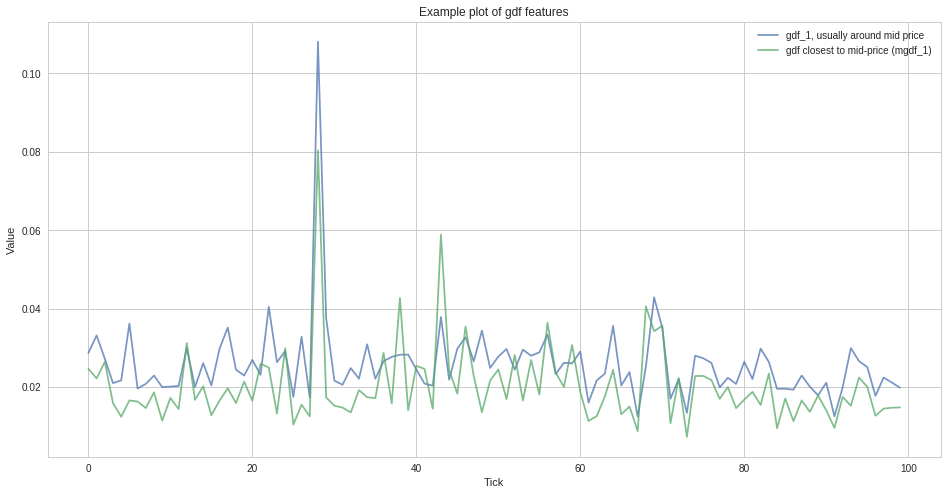

In [10]:
plt.figure(figsize=(16, 8))
plt.plot(df_gdf_example['gdf_1'].iloc[0:100], 
         label='gdf_1, usually around mid price', 
         alpha=0.75)
plt.plot(df_gdf_features_example['mgdf_1'].iloc[0:100], 
         label='gdf closest to mid-price (mgdf_1)', alpha=0.75)

plt.title('Example plot of gdf features')
plt.ylabel('Value')
plt.xlabel('Tick')
plt.legend()

## Initial predictions

We will try to do a few predictions if the `mid_price` will raise in the next tick (`mid_price_indicator` in the code) using SVM and logistic regression. In the other notebooks it's explored more.

We will use SVM and Logistic Regression, we will try a few different parameters, but hyperparameter tunning will not be performed here. This section is more for getting an idea what might work and what are the main obstacles in this approach of feature extraction.

We will use two kinds of features:
* "close" mid-price features
* fixed indexes features

In [11]:
def svm_classification(df, gdf_columns, C=1000, gamma=1):
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

def perform_svm_fixed_features(stock, length=10000, r=0.025, s=0.5, K=50, C=100, gamma=1, features_num=30):
    df, df_cv, df_test= lob.load_prepared_data(stock, data_dir='data/', cv=True, length=length)

    df_orders = transform_to_orders(df) 
    df_orders_cv = transform_to_orders(df_cv)
    df_orders_test = transform_to_orders(df_test)
    df_orders.head()

    df_gdf = transform_to_gdf(df_orders, r=r, s=s, K=K)
    df_gdf_cv = transform_to_gdf(df_orders_cv, r=r, s=s, K=K)
    df_gdf_test = transform_to_gdf(df_orders_test, r=r, s=s, K=K)

    cols = ['gdf_' + str(i) for i in range(int(K//2 - features_num//2), int(K//2 + features_num//2))]

    clf = svm_classification(df_gdf, cols, C=C, gamma=gamma)
    pred = clf.predict(df_gdf.loc[:, cols])
    pred_cv = clf.predict(df_gdf_cv.loc[:, cols])

    print('SVM with fixed indexes features:')
    print('Data preparation params: K = {}, s = {}, r = {}'.format(K, s, r))
    print('SVM hyperparams: gamma={}, C={}, fixed feature number: {}'.format(gamma, C, features_num))
    print('Training set ROC area score:', roc_auc_score(df_gdf['mid_price_indicator'], pred))
    print('Validation set ROC area score:', roc_auc_score(df_gdf_cv['mid_price_indicator'], pred_cv))

def perform_svm(stock, length=10000, r=0.025, s=0.5, K=50, C=100, gamma=1, features_num=30):
    df, df_cv, df_test= lob.load_prepared_data(stock, data_dir='data/', cv=True, length=length)

    df_orders = transform_to_orders(df) 
    df_orders_cv = transform_to_orders(df_cv)
    df_orders_test = transform_to_orders(df_test)
    df_orders.head()

    df_gdf = transform_to_gdf(df_orders, r=r, s=s, K=K)
    df_gdf_cv = transform_to_gdf(df_orders_cv, r=r, s=s, K=K)
    df_gdf_test = transform_to_gdf(df_orders_test, r=r, s=s, K=K)

    df_prepared = prepare_features(df_gdf, features_num)
    cols = ['mgdf_' + str(i) for i in range(0, features_num)]

    clf = svm_classification(df_prepared, cols, C=C, gamma=gamma)
    pred = clf.predict(df_prepared.loc[:, cols])

    df_prepared_cv = prepare_features(df_gdf_cv, features_num)
    pred_cv = clf.predict(df_prepared_cv.loc[:, cols])

    print('SVM with close mid-price features:')
    print('Data preparation params: K = {}, s = {}, r = {}'.format(K, s, r))
    print('SVM hyperparams: gamma={}, C={}, feature number: {}'.format(gamma, C, features_num))
    print('Training set ROC area score:', roc_auc_score(df_prepared['mid_price_indicator'], pred))
    print('Validation set ROC area score:', roc_auc_score(df_prepared_cv['mid_price_indicator'], pred_cv))
    
def perform_logistic(stock, r=0.025, s=0.5, K=50, features_num=30):
    df, df_cv, df_test= lob.load_prepared_data(stock, data_dir='data/', cv=True, length=length)

    df_orders = transform_to_orders(df) 
    df_orders_cv = transform_to_orders(df_cv)
    df_orders_test = transform_to_orders(df_test)
    df_orders.head()

    df_gdf = transform_to_gdf(df_orders, r=r, s=s, K=K)
    df_gdf_cv = transform_to_gdf(df_orders_cv, r=r, s=s, K=K)
    df_gdf_test = transform_to_gdf(df_orders_test, r=r, s=s, K=K)

    df_prepared = prepare_features(df_gdf, features_num)
    df_prepared_cv = prepare_features(df_gdf_cv, features_num)
    
    cols = ['mgdf_' + str(i) for i in range(0, features_num)]
    log_clf = LogisticRegressionCV()
    log_clf.fit(df_prepared.loc[:, cols], df_prepared['mid_price_indicator'])
    
    pred = log_clf.predict(df_prepared.loc[:, cols])
    pred_cv = log_clf.predict(df_prepared_cv.loc[:, cols])

    print('Logistic regression with close mid-price features:')
    print('Data preparation params: K = {}, s = {}, r = {}'.format(K, s, r))
    print('Logistic regression hyperparams: C={}, feature number: {}'.format(C, features_num))
    print('Training set ROC area score:', roc_auc_score(df_prepared['mid_price_indicator'], pred))
    print('Validation set ROC area score:', roc_auc_score(df_prepared_cv['mid_price_indicator'], pred_cv))
    
def perform_logistic_fixed_features(stock, r=0.025, s=0.5, K=50, features_num=30):
    df, df_cv, df_test= lob.load_prepared_data(stock, data_dir='data/', cv=True, length=length)

    df_orders = transform_to_orders(df) 
    df_orders_cv = transform_to_orders(df_cv)
    df_orders_test = transform_to_orders(df_test)
    df_orders.head()

    df_gdf = transform_to_gdf(df_orders, r=r, s=s, K=K)
    df_gdf_cv = transform_to_gdf(df_orders_cv, r=r, s=s, K=K)
    df_gdf_test = transform_to_gdf(df_orders_test, r=r, s=s, K=K)

    
    cols = ['gdf_' + str(i) for i in range(int(K//2 - features_num//2), int(K//2 + features_num//2))]
    log_clf = LogisticRegressionCV()
    log_clf.fit(df_gdf.loc[:, cols], df_gdf['mid_price_indicator'])
    
    pred = log_clf.predict(df_gdf.loc[:, cols])
    pred_cv = log_clf.predict(df_gdf_cv.loc[:, cols])

    print('Logistic regression with fixed indexes features:')
    print('Data preparation params: K = {}, s = {}, r = {}'.format(K, s, r))
    print('Logistic regression hyperparams: C={}, feature number: {}'.format(C, features_num))
    print('Training set ROC area score:', roc_auc_score(df_gdf['mid_price_indicator'], pred))
    print('Validation set ROC area score:', roc_auc_score(df_gdf_cv['mid_price_indicator'], pred_cv))

### K = 50, r = 0.025, s = 0.1

In [12]:
r = 0.025
s = 0.1
K = 50
stock = '9061'
C = 100
gamma = 1
features_num = 30

perform_svm(stock, r=r, s=s, K=K, C=C, gamma=gamma, features_num=features_num)

SVM with close mid-price features:
Data preparation params: K = 50, s = 0.1, r = 0.025
SVM hyperparams: gamma=1, C=100, feature number: 30
Training set ROC area score: 0.521159057744
Validation set ROC area score: 0.498128315484


In [13]:
perform_svm_fixed_features(stock, r=r, s=s, K=K, C=C, gamma=gamma, features_num=features_num)

SVM with fixed indexes features:
Data preparation params: K = 50, s = 0.1, r = 0.025
SVM hyperparams: gamma=1, C=100, fixed feature number: 30
Training set ROC area score: 0.541696893892
Validation set ROC area score: 0.52292563307


In [14]:
perform_logistic(stock, r=r, s=s, K=K, features_num=features_num)

Logistic regression with close mid-price features:
Data preparation params: K = 50, s = 0.1, r = 0.025
Logistic regression hyperparams: C=100, feature number: 30
Training set ROC area score: 0.5
Validation set ROC area score: 0.5


In [15]:
perform_logistic_fixed_features(stock, r=r, s=s, K=K, features_num=features_num)

Logistic regression with fixed indexes features:
Data preparation params: K = 50, s = 0.1, r = 0.025
Logistic regression hyperparams: C=100, feature number: 30
Training set ROC area score: 0.528759641443
Validation set ROC area score: 0.524567110399


### K = 30, r = 0.01, s = 0.01

In [16]:
r = 0.01
s = 0.01
stock = '9061'
features_num = 30
gamma= 1
C = 1000

perform_svm(stock, r=r, s=s, K=K, C=C, gamma=gamma, features_num=features_num)

SVM with close mid-price features:
Data preparation params: K = 50, s = 0.01, r = 0.01
SVM hyperparams: gamma=1, C=1000, feature number: 30
Training set ROC area score: 0.516860537836
Validation set ROC area score: 0.502997697928


In [17]:
perform_svm_fixed_features(stock, r=r, s=s, K=K, C=C, gamma=gamma, features_num=features_num)

SVM with fixed indexes features:
Data preparation params: K = 50, s = 0.01, r = 0.01
SVM hyperparams: gamma=1, C=1000, fixed feature number: 30
Training set ROC area score: 0.526695851574
Validation set ROC area score: 0.519452507257


In [18]:
perform_logistic(stock, r=r, s=s, K=K, features_num=features_num)

Logistic regression with close mid-price features:
Data preparation params: K = 50, s = 0.01, r = 0.01
Logistic regression hyperparams: C=1000, feature number: 30
Training set ROC area score: 0.5
Validation set ROC area score: 0.5


In [19]:
perform_logistic_fixed_features(stock, r=r, s=s, K=K, features_num=features_num)

Logistic regression with fixed indexes features:
Data preparation params: K = 50, s = 0.01, r = 0.01
Logistic regression hyperparams: C=1000, feature number: 30
Training set ROC area score: 0.530510735877
Validation set ROC area score: 0.520583525173


### K = 20, r = 0.01, s = 0.5

In [20]:
r = 0.01
s = 0.5
K = 30
stock = '9061'
features_num = 10
gamma= 1
C = 100

perform_svm(stock, r=r, s=s, K=K, C=C, gamma=gamma, features_num=features_num)

SVM with close mid-price features:
Data preparation params: K = 30, s = 0.5, r = 0.01
SVM hyperparams: gamma=1, C=100, feature number: 10
Training set ROC area score: 0.5
Validation set ROC area score: 0.5


In [21]:
perform_svm_fixed_features(stock, r=r, s=s, K=K, C=C, gamma=gamma, features_num=features_num)

SVM with fixed indexes features:
Data preparation params: K = 30, s = 0.5, r = 0.01
SVM hyperparams: gamma=1, C=100, fixed feature number: 10
Training set ROC area score: 0.501726078799
Validation set ROC area score: 0.500335301772


In [22]:
perform_logistic(stock, r=r, s=s, K=K, features_num=features_num)

Logistic regression with close mid-price features:
Data preparation params: K = 30, s = 0.5, r = 0.01
Logistic regression hyperparams: C=100, feature number: 10
Training set ROC area score: 0.515984990619
Validation set ROC area score: 0.503748373536


In [23]:
perform_logistic_fixed_features(stock, r=r, s=s, K=K, features_num=features_num)

Logistic regression with fixed indexes features:
Data preparation params: K = 30, s = 0.5, r = 0.01
Logistic regression hyperparams: C=100, feature number: 10
Training set ROC area score: 0.52548676256
Validation set ROC area score: 0.540486437794


## Conclusions

The main obstacle in GDF feature extraction approach is choosing the inital parameters K (number of segments), $\sigma$ (how wide is the filter) and $r$ (scale, how tall is it) for data preparation. These parameters have to be choosen before performing any prediction. It's impossible to say if the features extracted using these parameters will lead to dataset for which we will be able to do any preditions. 

After choosing feature extraction parameters, we still need to choose the right parameters for classifier - f.e. in case of SVM with rbf kernel there are two parameters to pick ($C$ and $\gamma$) along with the number of features we actually want to use.

This means that in total we have at least 5 parameters. It happens that wrong choice of feature extraction parameters $K$, $\sigma$ and $r$ easily leads to dataset on which is very hard to find proper hyperparameters for classifer.

We saw that potentially the approach with fixed indexes of gdf parameters works better.

### Next steps

We will perform more predictions for features obtained by fixed indexes gdf feature extraction approach. We will check if feature extraction parameters choice might be simplified.